# FPGheArt - Week 2 exercise

### Lorenzo Buriola - 2021860
### Filippo Conforto - 2021856
### Lorenzo Domenichetti - 2011653




In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD 
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

import time

### Data (strings) and splitting

In [2]:
fname="DATA/sequences16.csv"
sx, sy = np.loadtxt(fname,delimiter=',',
                   usecols= (0,1), unpack=True, dtype = str)

In [18]:
N = len(sy)
print(f"Number of total samples {N}")
Ls = len(sx[0])
print(f"Lenght of a sample {Ls}")

print(f"Sample: {sx[0]}, label: {sy[0]}")

perc_train = 0.8
N_train = int(N*perc_train)
N_test = N -N_train
print(f'\ndata:{N}\ntrain: {N_train}\ntest: {N_test}')

Number of total samples 3000
Lenght of a sample 16
Sample: AAGGTCTGCCGGCCGA, label: 1

data:3000
train: 2400
test: 600


In [4]:
Q = ['A', 'C', 'G', 'T']
Nc=4
onehc = {Q[i]: i for i in range(Nc)}
print(f"One-hot encoding dictionary: {onehc}")

{'A': 0, 'C': 1, 'G': 2, 'T': 3}


### Data conversion: One-Hot Encoding



In [24]:
y = sy.astype(int)

L = Ls*Nc
print(f"Product of lenght ({Ls}) and character possibilities ({Nc}): {L}\n")

x= np.zeros((N,L))

for n in range(N):
    for i in range(Ls):
        x[n][i*4 + onehc[sx[n][i]]] = 1
print(f"Original sequence:\n {sx[0]}\n")
print(f"Encoded sequence:\n {x[0]}")

Product of lenght (16) and character possibilities (4): 64

Original sequence:
 AAGGTCTGCCGGCCGA

Encoded sequence:
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.
 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]


### Split train/test - validation

In [26]:
(x_train, y_train) = (x[:N_train], y[:N_train])
(x_test, y_test) = (x[N_train:], y[N_train:])
print(f"Ratio between y_train labels sum and train samples: {y_train.sum() / N_train}")
print(f"Ratio between y_test  labels sum and test samples: {y_test.sum() / N_test}")


Ratio between y_train labels sum and train samples: 0.24333333333333335
Ratio between y_test  labels sum and test samples: 0.25833333333333336


### Definition of model in Keras

In [30]:
np.random.seed(123)

model = Sequential()

model.add(Dense(L,input_shape=(L,),activation = "relu"))
model.add(Dense(L/2,activation = "relu"))
model.add(Dense(L/4,activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(1,activation="sigmoid"))

model.summary()

Model: "sequential_460"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1840 (Dense)           (None, 64)                4160      
_________________________________________________________________
dense_1841 (Dense)           (None, 32)                2080      
_________________________________________________________________
dense_1842 (Dense)           (None, 16)                528       
_________________________________________________________________
dropout_460 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_1843 (Dense)           (None, 1)                 17        
Total params: 6,785
Trainable params: 6,785
Non-trainable params: 0
_________________________________________________________________


In [32]:
model.compile(loss="binary_crossentropy",
             optimizer="adam",
             metrics= ["accuracy"])

In [33]:
fit = model.fit(x_train, y_train,
                epochs=30, batch_size = 50, validation_data = (x_test,y_test), shuffle = True,)


Epoch 1/30
48/48 [==============================] - 1s 5ms/step - loss: 0.6580 - accuracy: 0.5789 - val_loss: 0.5612 - val_accuracy: 0.7417
Epoch 2/30
48/48 [==============================] - 0s 2ms/step - loss: 0.5599 - accuracy: 0.7468 - val_loss: 0.5288 - val_accuracy: 0.7417
Epoch 3/30
48/48 [==============================] - 0s 2ms/step - loss: 0.4968 - accuracy: 0.7630 - val_loss: 0.5006 - val_accuracy: 0.7450
Epoch 4/30
48/48 [==============================] - 0s 2ms/step - loss: 0.4675 - accuracy: 0.7699 - val_loss: 0.4908 - val_accuracy: 0.7550
Epoch 5/30
48/48 [==============================] - 0s 2ms/step - loss: 0.4273 - accuracy: 0.8033 - val_loss: 0.4861 - val_accuracy: 0.7700
Epoch 6/30
48/48 [==============================] - 0s 2ms/step - loss: 0.4398 - accuracy: 0.7955 - val_loss: 0.4853 - val_accuracy: 0.7633
Epoch 7/30
48/48 [==============================] - 0s 2ms/step - loss: 0.4160 - accuracy: 0.8172 - val_loss: 0.4862 - val_accuracy: 0.7667
Epoch 8/30
48/48 [==

19/19 [==============================] - 0s 1ms/step - loss: 0.8250 - accuracy: 0.8067
Final Test loss: 0.8249985575675964
Final Test accuracy: 0.8066666722297668


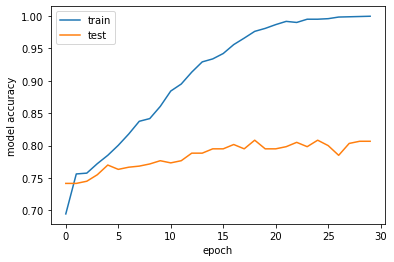

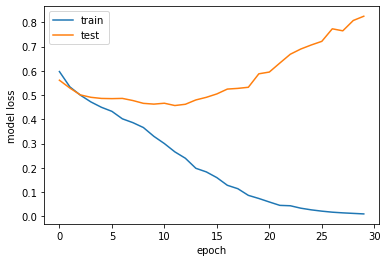

In [34]:
# evaluate model
score = model.evaluate(x_test, y_test, verbose=1)

# print performance
print('Final Test loss:', score[0])
print('Final Test accuracy:', score[1])

# look into training history

# summarize history for accuracy
plt.plot(fit.history['accuracy'])
plt.plot(fit.history['val_accuracy'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# summarize history for loss
plt.plot(fit.history['loss'])
plt.plot(fit.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

## Data augmentation

In [11]:
augval = np.asarray([[[sx[0][-i:] + sx[0][:-i],vy] for i in range(16)] for v,vy in zip(sx[:N_train],y[:N_train])]).reshape(38400,2)
augsx = augval[:,0]
augy_train = augval[:,1].astype(int)

In [12]:
augx_train = np.zeros((N_train*16,L))

for n in range(N_train*16):
    for i in range(Ls):
        augx_train[n][i*4 + onehc[augsx[n][i]]] = 1
aug_N_train = N_train*16


### Split train/test - validation

In [13]:
fit2 = model.fit(augx_train, augy_train,
                epochs=30, batch_size = 50, validation_data = (x_test,y_test), shuffle = True,)


Epoch 1/30
768/768 [==============================] - 1s 1ms/step - loss: 0.5948 - accuracy: 0.7531 - val_loss: 0.5080 - val_accuracy: 0.7450
Epoch 2/30
768/768 [==============================] - 1s 954us/step - loss: 0.5616 - accuracy: 0.7567 - val_loss: 0.4954 - val_accuracy: 0.7483
Epoch 3/30
768/768 [==============================] - 1s 954us/step - loss: 0.5597 - accuracy: 0.7567 - val_loss: 0.5108 - val_accuracy: 0.7450
Epoch 4/30
768/768 [==============================] - 1s 982us/step - loss: 0.5589 - accuracy: 0.7567 - val_loss: 0.5139 - val_accuracy: 0.7433
Epoch 5/30
768/768 [==============================] - 1s 977us/step - loss: 0.5584 - accuracy: 0.7567 - val_loss: 0.5172 - val_accuracy: 0.7450
Epoch 6/30
768/768 [==============================] - 1s 956us/step - loss: 0.5571 - accuracy: 0.7566 - val_loss: 0.5233 - val_accuracy: 0.7450
Epoch 7/30
768/768 [==============================] - 1s 980us/step - loss: 0.5566 - accuracy: 0.7565 - val_loss: 0.5237 - val_accuracy: 0

19/19 [==============================] - 0s 1ms/step - loss: 0.5632 - accuracy: 0.7417

Test loss: 0.5631608366966248
Test accuracy: 0.7416666746139526


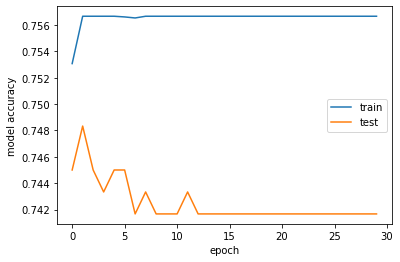

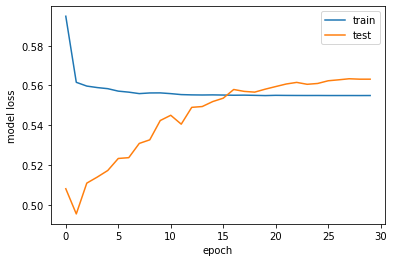

In [14]:
# evaluate model
score = model.evaluate(x_test, y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# look into training history

# summarize history for accuracy
plt.plot(fit2.history['accuracy'])
plt.plot(fit2.history['val_accuracy'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# summarize history for loss
plt.plot(fit2.history['loss'])
plt.plot(fit2.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

## GridSearch

In [15]:
def create_DNN(activation, dropout_rate):
    model = Sequential()

    model.add(Dense(L,input_shape=(L,),activation = activation))
    model.add(Dense(L/2,activation = activation))
    model.add(Dense(L/4,activation = activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1,activation="sigmoid"))
    return model


In [16]:
def compile_model(optimizer=keras.optimizers.Adam(), activation = "relu", dropout_rate = 0.2):
    # create the mode
    model=create_DNN(activation, dropout_rate)
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model


In [17]:
# call Keras scikit wrapper
model_gridsearch = KerasClassifier(build_fn = compile_model)

# list of allowed optional arguments for the optimizer, see `compile_model()`
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# define parameter dictionary
param_grid = dict(optimizer=optimizer, activation = activation, dropout_rate=dropout_rate)
# call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=1, cv=4)
grid_result = grid.fit(x_train,y_train, epochs=30, batch_size = 50, shuffle = True)


Epoch 1/30
Epoch 1/30


C:\Users\loren\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\loren\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\loren\anaconda3\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 223, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "C:\Users\loren\anaconda3\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 166, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\Users\loren\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py", line 1100, in fit
    tmp_logs = self.train_function(iterator)
  File "C:\Users\loren\anaconda3\lib\site-packages\tensorflow\python\eager

Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30

KeyboardInterrupt: 

In [ ]:
param_grid